# Figure 7: radio afterglow

## Loading the BHNS population

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4 = table['snr_LVKO4'][()]
snr_LVKO4_duty = table['snr_LVKO4_duty'][()]
snr_LO4_duty = table['snr_LO4_duty'][()]
snr_LO4 = table['snr_LO4'][()]
snr_LVKIO5 = table['snr_LVKIO5'][()]
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()]
snr_LVKO5_duty = table['snr_LVKO5_duty'][()]

sky_loc_LVKO4 = table['sky_loc_LVKO4'][()]
sky_loc_LVKIO5 = table['sky_loc_LVKIO5'][()]
sky_loc_LO4 = table['sky_loc_LO4'][()]
sky_loc_LVKO4_duty = table['sky_loc_LVKO4_duty'][()]
sky_loc_LO4_duty = table['sky_loc_LO4_duty'][()]
sky_loc_LVKIO5_duty = table['sky_loc_LVKIO5_duty'][()]
sky_loc_LVKO5_duty = table['sky_loc_LVKO5_duty'][()]

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands = g, z, J
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


## Weighing the BHNS population

In [3]:
### --- Weights --- ###

if poptype == 'A':
    w_type='w_000'
    r0 = 149 
    w_type_high = 'w_000'
    r0_high = 302
    w_type_low = 'w_000'
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000'
    r0_high = 100
    w_type_low = 'w_000'
    r0_low = 10

spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights
Computing weights
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



In [4]:
### --- Limiting Thresholds --- ###
print("O4 detection limits")

lim_snr = 12.
lim_snr_sub = 6.

lim_kn = np.array([22.,22.,21.]) #22 22 21

lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])

lim_prompt_fermi = 4.
lim_prompt_swift = 3.5

#GW
snr_O4 = snr_LVKO4_duty
gw_det_O4 = snr_O4 >= lim_snr
gw_det_O4_sub = snr_O4 >= lim_snr_sub

snr_O5 = snr_LVKIO5_duty
gw_det_O5 = snr_O5 >= lim_snr

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_z = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
    grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]
grb_det_radio_15 = grb_det_15[:,0]
grb_det_optic_15 = grb_det_15[:,1]
grb_det_x_15 = grb_det_15[:,2]
grb_det_all_15 = np.max(grb_det_15, axis = 1)

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = flux_prompt[:,0,0] >= lim_prompt_fermi
prompt_det_fermi_15 = flux_prompt[:,0,1] >= lim_prompt_fermi
prompt_det_swift = flux_prompt[:,1,0] >= lim_prompt_swift
prompt_det_swift_15 = flux_prompt[:,1,1] >= lim_prompt_swift 

print("O5 detection limits")

lim_snr_O5 = 12

lim_kn_O5 = np.array([26.,24.4,21.])

lim_grb_O5 = np.asarray([1.e-2,1.5e-4,1.5e-6])

lim_prompt_fermi_O5 = 4.
lim_prompt_swift_O5 = 3.5

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det_O5 = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det_O5[:,j] = kn_peak_APP <= lim_kn_O5[j]
kn_det_all_O5 = np.max(kn_det_O5, axis = 1)
kn_det_g_O5 = kn_det_O5[:,0]
kn_det_z_O5 = kn_det_O5[:,1]
kn_det_J_O5 = kn_det_O5[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det_O5 = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_O5_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det_O5[:,j] = grb_peak[:,j,0] >= lim_grb_O5[j]
    grb_det_O5_15[:,j] = grb_peak[:,j,1] >= lim_grb_O5[j]
grb_det_all_O5 = np.max(grb_det_O5, axis = 1)
grb_det_radio_O5 = grb_det_O5[:,0]
grb_det_optic_O5 = grb_det_O5[:,1]
grb_det_x_O5 = grb_det_O5[:,2]
grb_det_radio_O5_15 = grb_det_O5_15[:,0]
grb_det_optic_O5_15 = grb_det_O5_15[:,1]
grb_det_x_O5_15 = grb_det_O5_15[:,2]

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi_O5 = flux_prompt[:,0,0] >= lim_prompt_fermi_O5
prompt_det_fermi_O5_15 = flux_prompt[:,0,1] >= lim_prompt_fermi_O5
prompt_det_swift_O5 = flux_prompt[:,0,0] >= lim_prompt_swift_O5
prompt_det_swift_O5_15 = flux_prompt[:,0,1] >= lim_prompt_swift_O5

O4 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
O5 detection limits
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds


In [5]:
# transform absolute magnitudes to apparent
lc_kn_APP = np.zeros([num,len(kn_waves),len(t_kn)])

for i in range(len(kn_waves)):
    for j in range(len(t_kn)):
        lc_kn_APP[:,i,j] = abs_to_app(lc_kn[:,i,j],dL*1.e6)

mpk_g = np.min(lc_kn_APP[:,0], axis=1)
mpk_z = np.min(lc_kn_APP[:,1], axis=1)
mpk_J = np.min(lc_kn_APP[:,2], axis=1)

In [6]:
## Here are the instrument characteristics to use for the observing strategies.

# Optical
lsst_fov = 9.6 #* Deg2
ztf_fov = 47.7 #* Deg2
lsst_survey_cadence = 3 # day
ztf_survey_cadence = 1 # day
lsst_tiling_cadence = 1 / 24 # 1h
ztf_tiling_cadence = 1 / 24 # 1h

lsst_d = {'g' : 26.0, # 180 s
'z' : 24.5} # 180 s

lsst_d_min = {'g' : 25.0, # 30 s
'z' : 23.5} # 30 s

growth_d = {'g' : 22, # 90 s
'z' : 20.9, # GROWTH-India, 600 s
'J' : 16, # 65s
           }

# Radio DSA-2000
dsa_lim = 1.e-3 # miliJy
dsa_fov = 10.6 # Deg2
dsa_cadence = 1 / 24 # = 1 hour

# Radio ngVLA
ngvla_fov = 0.13 # Deg2 = 24^2 arcmin2
ngvla_cadence = (1./6) / 24 # = 10 min
ngvla_lim = 1.e-3 # miliJy


# Radio SKA1
ska1_lim = 2.e-3 # miliJy
ska1_fov = 0.0167 # 60 arcmin2
ska1_cadence = 4 / 24 # = 4 hour


# Radio SKA2
ska2_lim = 2.e-4 # miliJy
ska2_fov = 0.333 # 60 arcmin2
ska2_cadence = 4 / 24 # = 4 hour



# Generic kilonova limits
gen_d = {'g' : 24, # Generic KN limits
'z' : 22.5,
#'J' : 18,
}

In [7]:
# Extract radio afterglow peak times
grb_tpk = np.zeros_like(grb_peak[:,0,0])
grb_tpk_15 = np.zeros_like(grb_peak[:,0,1])

for i in range(len(grb_peak)):
    grb_tpk[i] = t_grb[np.argmax(lc_grb[i, 0, :, 0])]
    grb_tpk_15[i] = t_grb[np.argmax(lc_grb[i, 0, :, 1])]

In [8]:
# Extract duration of afterglow above radio threshold
deltat_ag = np.zeros_like(grb_tpk)
deltat_ag_15 = np.zeros_like(grb_tpk)

for i in range(len(deltat_ag)):
    above_time = t_grb[(lc_grb[i, 0, :, 0] > 0.01)]
    if len(above_time) == 0:
        continue
    if len(above_time) == 1:
        deltat_ag[i] = above_time.max() * (1 - 10**(-0.08163))
    else:
        deltat_ag[i] = above_time.max() - above_time.min()
        
for i in range(len(deltat_ag_15)):
    above_time = t_grb[(lc_grb[i, 0, :, 1] > 0.01)]
    if len(above_time) == 0:
        continue
    if len(above_time) == 1:
        deltat_ag_15[i] = above_time.max() * (1 - 10**(-0.08163))
    else:
        deltat_ag_15[i] = above_time.max() - above_time.min()

In [9]:
# O4, GEN
for i in [0, 1]:
    print(f"i = {i}, theta_j = {3.4 if i == 0 else 15}")
    fil_gw = (snr_O4 > 12)
    fil_ag = (m_out>0) & (grb_peak[:,0,i]>0.01)
    fil_kn = (m_out>0) & ((mpk_g < gen_d['g']) | (mpk_z < gen_d['z']))
    fil_grb =  (m_out > 0) & (prompt_det_fermi)

    print("O4 + GEN")
    print(f"Selection by GW {fil_gw.sum()}, {w[fil_gw].sum()}")
    print(f"Selection by GW+KN {fil_kn.sum()}, {w[fil_kn].sum()}")
    print(f"Selection by GW+AG {fil_ag.sum()}, {w[fil_ag].sum()}")
    print(f"Selection by GW+AG+KN {(fil_ag&fil_kn).sum()}, {w[fil_ag&fil_kn].sum()}")
    print(f"Selection by GW+AG-KN {(fil_ag&~fil_kn).sum()}, {w[fil_ag&~fil_kn].sum()}")
    print(f"Selection by GW+AG-KN+GRB {(fil_ag&(~fil_kn)&(prompt_det_fermi)).sum()}, {w[fil_ag&(~fil_kn)&(prompt_det_fermi)].sum()}")

    print(f"{w[fil_ag&fil_kn&fil_gw].sum() / w[fil_ag&fil_gw].sum()}")
    print(f"{w[fil_ag&(~fil_kn)&fil_gw].sum() / w[fil_ag&fil_gw].sum()}")
    print(f"{w[fil_ag&(~fil_kn)&fil_gw&(~fil_grb)].sum() / w[fil_ag&fil_gw].sum()}")

i = 0, theta_j = 3.4
O4 + GEN
Selection by GW 337787, 1.5392588143141805
Selection by GW+KN 79872, 0.3739957566163782
Selection by GW+AG 76167, 0.148130522239856
Selection by GW+AG+KN 59097, 0.01002512619215597
Selection by GW+AG-KN 17070, 0.1381053960477
Selection by GW+AG-KN+GRB 14569, 0.10009650271592038
0.999488927383283
0.00051107261671712
0.0
i = 1, theta_j = 15
O4 + GEN
Selection by GW 337787, 1.5392588143141805
Selection by GW+KN 79872, 0.3739957566163782
Selection by GW+AG 71393, 0.039680991215852716
Selection by GW+AG+KN 61885, 0.019331112006462002
Selection by GW+AG-KN 9508, 0.020349879209390714
Selection by GW+AG-KN+GRB 6963, 0.009993826695013282
1.0000000000000002
0.0
0.0


In [10]:
# O5, GEN
for i in [0, 1]:
    print(f"i = {i}, theta_j = {3.4 if i == 0 else 15}")
    fil_gw = (snr_O5 > 12)
    fil_ag = (m_out>0) & (grb_peak[:,0,i]>0.01)
    fil_kn = (m_out>0) & ((mpk_g < gen_d['g']) | (mpk_z < gen_d['z']))

    print("O5 + GEN")
    print(f"Selection by GW {fil_gw.sum()}, {w[fil_gw].sum()}")
    print(f"Selection by GW+KN {fil_kn.sum()}, {w[fil_kn].sum()}")
    print(f"Selection by GW+AG {fil_ag.sum()}, {w[fil_ag].sum()}")
    print(f"Selection by GW+AG+KN {(fil_ag&fil_kn).sum()}, {w[fil_ag&fil_kn].sum()}")
    print(f"Selection by GW+AG-KN {(fil_ag&~fil_kn).sum()}, {w[fil_ag&~fil_kn].sum()}")
    print(f"Selection by GW+AG-KN+GRB {(fil_ag&(~fil_kn)&(prompt_det_fermi)).sum()}, {w[fil_ag&(~fil_kn)&(prompt_det_fermi)].sum()}")

    print(f"w/ KN: {w[fil_ag&fil_kn&fil_gw].sum() / w[fil_ag&fil_gw].sum()}")
    print(f"w/o KN: {w[fil_ag&(~fil_kn)&fil_gw].sum() / w[fil_ag&fil_gw].sum()}")
    print(f"w/o KN nor GRB: {w[fil_ag&(~fil_kn)&fil_gw&(~fil_grb)].sum() / w[fil_ag&fil_gw].sum()}")

i = 0, theta_j = 3.4
O5 + GEN
Selection by GW 443913, 14.2854584682565
Selection by GW+KN 79872, 0.3739957566163782
Selection by GW+AG 76167, 0.148130522239856
Selection by GW+AG+KN 59097, 0.01002512619215597
Selection by GW+AG-KN 17070, 0.1381053960477
Selection by GW+AG-KN+GRB 14569, 0.10009650271592038
w/ KN: 0.6717747246829898
w/o KN: 0.32822527531700996
w/o KN nor GRB: 0.11709006668713969
i = 1, theta_j = 15
O5 + GEN
Selection by GW 443913, 14.2854584682565
Selection by GW+KN 79872, 0.3739957566163782
Selection by GW+AG 71393, 0.039680991215852716
Selection by GW+AG+KN 61885, 0.019331112006462002
Selection by GW+AG-KN 9508, 0.020349879209390714
Selection by GW+AG-KN+GRB 6963, 0.009993826695013282
w/ KN: 0.7403155668503622
w/o KN: 0.25968443314963807
w/o KN nor GRB: 0.15037428126523997


In [11]:
from scipy.ndimage import gaussian_filter as gf

def smoothing(H,sm):
    g = gf(H,sm)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(),g.shape)
    return c

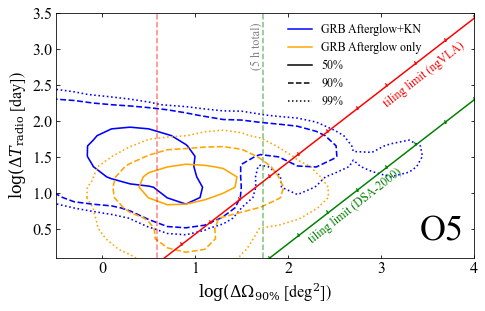

In [13]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

sky_loc_O5 = sky_loc_LVKIO5_duty

ymin = -1
ymax = 2.5
xmin = 0
xmax = 2.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

alphapp = 25 * np.pi / 180
rpp = 500
verts=[[0, 0],[rpp*np.cos(alphapp), rpp*np.sin(alphapp)],
       [0.5 * rpp * np.cos(alphapp) - 3 * rpp * np.sin(alphapp),0.5 * rpp * np.sin(alphapp) + 3 * rpp * np.cos(alphapp)],
      [0, 0]]

X = 10000
om_l = 10**np.linspace(-1-1, 4, 20)
fil_gw = (snr_O5>12)
w_0 = w[fil_gw].max()

# AG with KN
fil = fil_gw&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &((mpk_g< gen_d['g']) | (mpk_z< gen_d['z']))  & (X * w / w_0 > 0.1)           

range_lim = [[-1,5.],[-1,3.3]]
bins = 30

H, xedges, yedges= np.histogram2d(np.log10(sky_loc_O5[fil]),np.log10(deltat_ag[fil]),
                                  weights=w[fil],bins=bins,range=range_lim)
c = smoothing(H,1.3)
xcentre = np.zeros(bins)
ycentre = np.zeros(bins)
for j in range(len(xedges)-1):
    xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
for j in range(len(yedges)-1):
    ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(T,M,c,levels=[0.05, 0.1,0.5],colors='blue',linestyles=[':', '--', '-'],linewidths=1.6,zorder=2)

# AG without KN
fil = fil_gw&(m_out>0)&(grb_peak[:,0,0] > 0.01)\
      &(~((mpk_g< gen_d['g']) | (mpk_z< gen_d['z'])))  & (X * w / w_0 > 0.1)          

H, xedges, yedges= np.histogram2d(np.log10(sky_loc_O5[fil]),np.log10(deltat_ag[fil]),
                                  weights=w[fil],bins=bins,range=range_lim)
c = smoothing(H,1.3)
xcentre = np.zeros(bins)
ycentre = np.zeros(bins)
for j in range(len(xedges)-1):
    xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
for j in range(len(yedges)-1):
    ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(T,M,c,levels=[0.01, 0.1,0.5],colors='orange',linestyles=[':', '--', '-'],linewidths=1.6,zorder=2)

# DSA and SKA tiling
plt.plot(np.log10(om_l), np.log10(5* dsa_cadence * om_l / dsa_fov), color='green', marker=verts)
plt.plot(np.log10(om_l), np.log10(5* ngvla_cadence * om_l / ngvla_fov), color='red', marker=verts)
plt.text(2.2, 0.3, r'tiling limit (DSA-2000)', rotation=38, color='green',size=12)
plt.text(3., 2.2, r'tiling limit (ngVLA)', rotation=38, color='red',size=12)


plt.ylabel(r'$\log (\Delta T_{\rm{radio}}$ [day])',size=16)
plt.xlabel(r'$\log (\Delta \Omega_{90\%}$ [deg$^2$])',size=16)

plt.plot([-100], [-100], linestyle='-', label=r'GRB Afterglow+KN', color='blue')
plt.plot([-100], [-100], linestyle='-', label=r'GRB Afterglow only', color='orange')
plt.plot([-100], [-100], linestyle='-', label='50%', color='black')
plt.plot([-100], [-100], linestyle='--', label='90%', color='black')
plt.plot([-100], [-100], linestyle=':', label='99%', color='black')

plt.axvline(np.log10(5 * dsa_fov / (dsa_cadence * 24)), color='green', linestyle='--', alpha=0.5)

plt.axvline(np.log10(5 * ngvla_fov / (ngvla_cadence * 24)), color='red', linestyle='--', alpha=0.5)

plt.text(np.log10(5 * dsa_fov / (dsa_cadence * 24))- 0.13, 2.75, r'(5 h total)',
         rotation=90, color='grey', size=12)

plt.legend(loc='upper right', bbox_to_anchor=(0.9,1.), prop={'size': 12},frameon=False)
plt.xlim([-0.5, 4])
plt.ylim([0.1, 3.5])
plt.tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=16)
plt.annotate('O5', xy=(0.87, 0.07), xycoords='axes fraction',size=36)

plt.savefig(f'fig3-O5.pdf', bbox_inches='tight')